<a href="https://colab.research.google.com/github/AJH0625/NLP-study/blob/main/CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-1.67231455 -1.4399733   1.02932893 -0.32425508 -0.37956025 -1.39005227
   0.69861833]]


In [2]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'I got my peaches out in Georgia.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 5 6 7]
{0: 'i', 1: 'got', 2: 'my', 3: 'peaches', 4: 'out', 5: 'in', 6: 'georgia', 7: '.'}


In [3]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [4]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [5]:
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'I got my peaches out in Georgia.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [6]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

In [7]:
 def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

In [8]:
def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 26 |

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

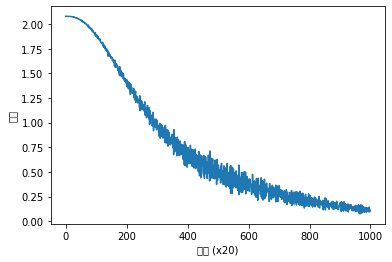

In [11]:
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot
from simple_cbow import SimpleCBOW

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'I got my peaches out in Georgia.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [12]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

i [-0.19622332 -0.77217776  1.4178035   0.7798203  -1.4958967 ]
got [-0.9517855  1.020071  -1.3155175 -1.0262622  1.4131855]
my [ 1.1535368 -1.3480827  1.506214   1.3668265 -1.40619  ]
peaches [-1.6402209   1.1685367  -0.52390265 -1.1756378  -0.0639786 ]
out [ 1.5307273 -1.3438529 -0.8621572  1.3421191  1.1384897]
in [-0.3374046  1.2705016  1.4285258 -1.29763   -1.4119443]
georgia [ 0.92119443 -0.81229115 -1.3661996   0.80745614  1.3813533 ]
. [ 1.7386235  1.133494   1.1444728 -1.1235904  0.4427994]
